# **Heart Disease Classification**

## Data Preparation

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [72]:
data = pd.read_csv('https://storage.googleapis.com/applied-dl/heart.csv')
data.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,1,145,233,1,2,150,0,2.3,3,0,fixed,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,normal,1
2,67,1,4,120,229,0,2,129,1,2.6,2,2,reversible,0
3,37,1,3,130,250,0,0,187,0,3.5,3,0,normal,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,normal,0


In [73]:
print('Shape of Data : ', data.shape)

Shape of Data :  (303, 14)


In [74]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age         303 non-null int64
sex         303 non-null int64
cp          303 non-null int64
trestbps    303 non-null int64
chol        303 non-null int64
fbs         303 non-null int64
restecg     303 non-null int64
thalach     303 non-null int64
exang       303 non-null int64
oldpeak     303 non-null float64
slope       303 non-null int64
ca          303 non-null int64
thal        303 non-null object
target      303 non-null int64
dtypes: float64(1), int64(12), object(1)
memory usage: 33.3+ KB


In [75]:
print("Number of target variable : ", data['target'].nunique())

Number of target variable :  2


Attribute Information: 

1. **age** 
2. **sex** 
3. **cp** or chest pain type (4 values) 
4. **trestbps** or resting blood pressure 
5. **chol** or serum cholestoral in mg/dl 
6. **fbs** or fasting blood sugar > 120 mg/dl
7. **restecg** or resting electrocardiographic results (values 0,1,2)
8. **thalach** or maximum heart rate achieved 
9. **exang** or exercise induced angina 
10. **oldpeak** = ST depression induced by exercise relative to rest 
11. the **slope** of the peak exercise ST segment 
12. **ca** or number of major vessels (0-3) colored by flourosopy 
13. **thal**: 3 = normal; 6 = fixed defect; 7 = reversable defect

In [76]:
data.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.594059,0.676568,3.108911,131.785479,246.547855,0.148515,0.990099,149.194719,0.326733,1.057756,1.590759,0.683168,0.273927
std,9.016370,0.468560,1.028414,17.748338,52.175933,0.356198,0.988293,23.173368,0.469794,1.165025,0.617767,0.937773,0.446710
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,48.000000,0.000000,2.000000,120.000000,211.000000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,0.000000
50%,56.000000,1.000000,3.000000,130.000000,241.000000,0.000000,1.000000,152.000000,0.000000,0.800000,2.000000,0.000000,0.000000
75%,61.000000,1.000000,4.000000,140.000000,275.000000,0.000000,2.000000,165.500000,1.000000,1.600000,2.000000,1.000000,1.000000
max,77.000000,1.000000,4.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,3.000000,3.000000,1.000000


## Exploratory Data Analysis

**1. Warming up**

Frequency distribution of **target** variable 

(0 : Absence of heart disease, 1 : Presence of heart disease)

In [77]:
data['target'].value_counts()

0    220
1     83
Name: target, dtype: int64

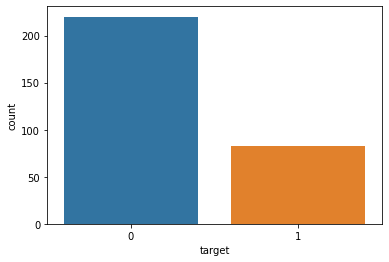

In [78]:
sns.countplot(x = "target", data = data)
plt.show()

That looks like a pretty well-distributed dataset, considering the number of rows.

Frequency distribution of **sex** with respect to **target**

In [79]:
data.groupby('sex')['target'].value_counts()

sex  target
0    0          82
     1          16
1    0         138
     1          67
Name: target, dtype: int64

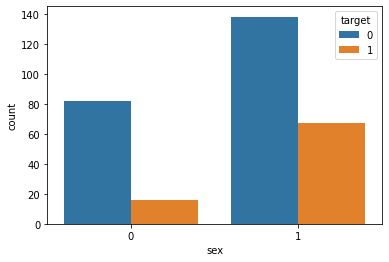

In [80]:
sns.countplot(x = "sex", hue = "target", data = data)
plt.show()

**2. Estimating correlation coefficient**

In [81]:
correlation = data.corr()
correlation['target'].sort_values(ascending = False)

target      1.000000
ca          0.476613
oldpeak     0.475324
cp          0.381725
exang       0.361026
slope       0.359572
age         0.198701
sex         0.171564
trestbps    0.129389
restecg     0.126169
fbs         0.097252
chol        0.083327
thalach    -0.386459
Name: target, dtype: float64

As we can see that the **cp** and **thalach** variables are mildly positively correlated with **target** variable. 

So, We will analyze the interaction between these features and **target** variable

Frequency distribution of **cp**

**cp** stands for chest pain type (4 values)



In [82]:
data['cp'].value_counts()

4    142
3     84
2     49
1     24
0      4
Name: cp, dtype: int64

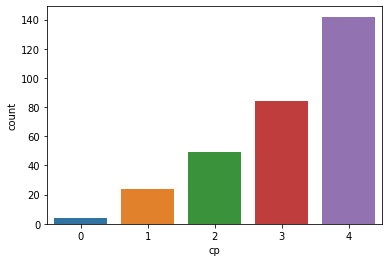

In [83]:
sns.countplot(x = "cp", data = data)
plt.show()

Analysis of **cp** and **target** variable

In [84]:
data.groupby('cp')['target'].value_counts()

cp  target
0   0          4
1   0         22
    1          2
2   0         46
    1          3
3   0         75
    1          9
4   0         73
    1         69
Name: target, dtype: int64

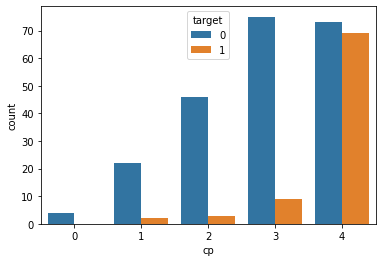

In [85]:
sns.countplot(x = "cp", hue = "target", data = data)
plt.show()

Explore **thalach** variable


**thalach** stands for maximum heart rate achieved

In [86]:
data['thalach'].nunique()

91

Analysis of **thalach** and **target** variable

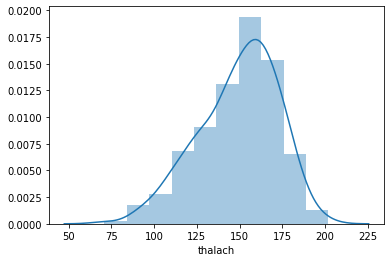

In [87]:
sns.distplot(data['thalach'], bins = 10)
plt.show()

From the above plot, We can see that the **thalach** variable is slightly negatively skewed

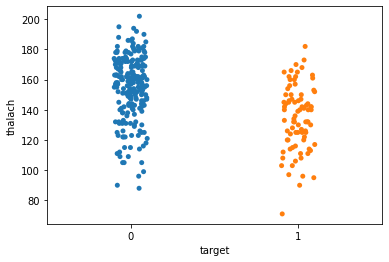

In [88]:
sns.stripplot(x = "target", y = "thalach", data = data)
plt.show()

From the above plot, We can see that people suffering from heart disease (target = 1) have relatively higher heart rate (**thalach**) as compared to people who are not suffering from heart disease (target = 0)

**3. Discovering Pattern and Relationship in Dataset**

Heat Map

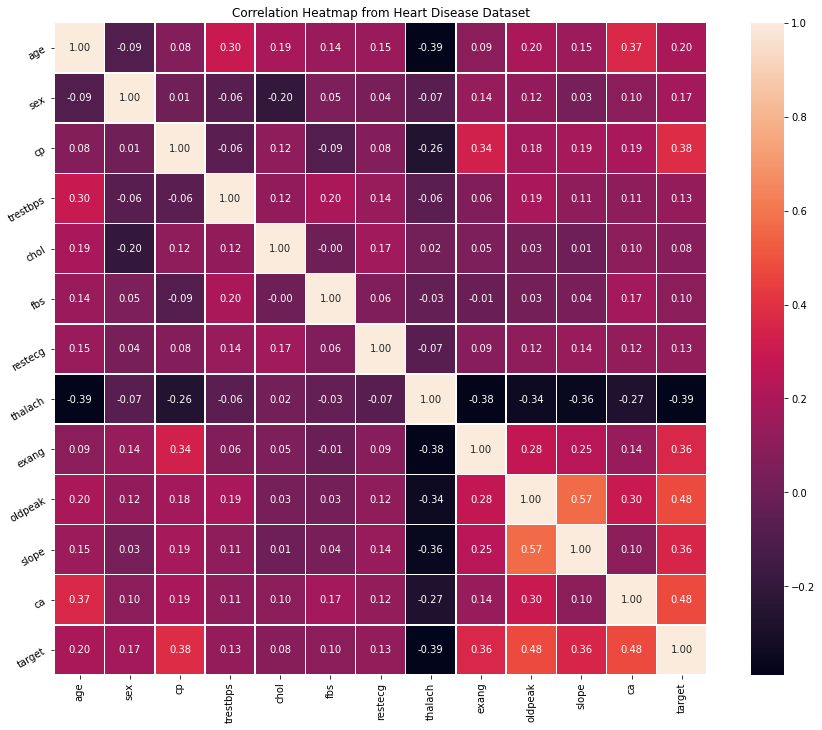

In [89]:
plt.figure(figsize = (16,12))
plt.title('Correlation Heatmap from Heart Disease Dataset')
a = sns.heatmap(correlation, square = True, annot = True, fmt = '.2f', linewidths = .5)
a.set_xticklabels(a.get_xticklabels(), rotation = 90)
a.set_yticklabels(a.get_yticklabels(), rotation = 30)           
plt.show()

Pair Plot

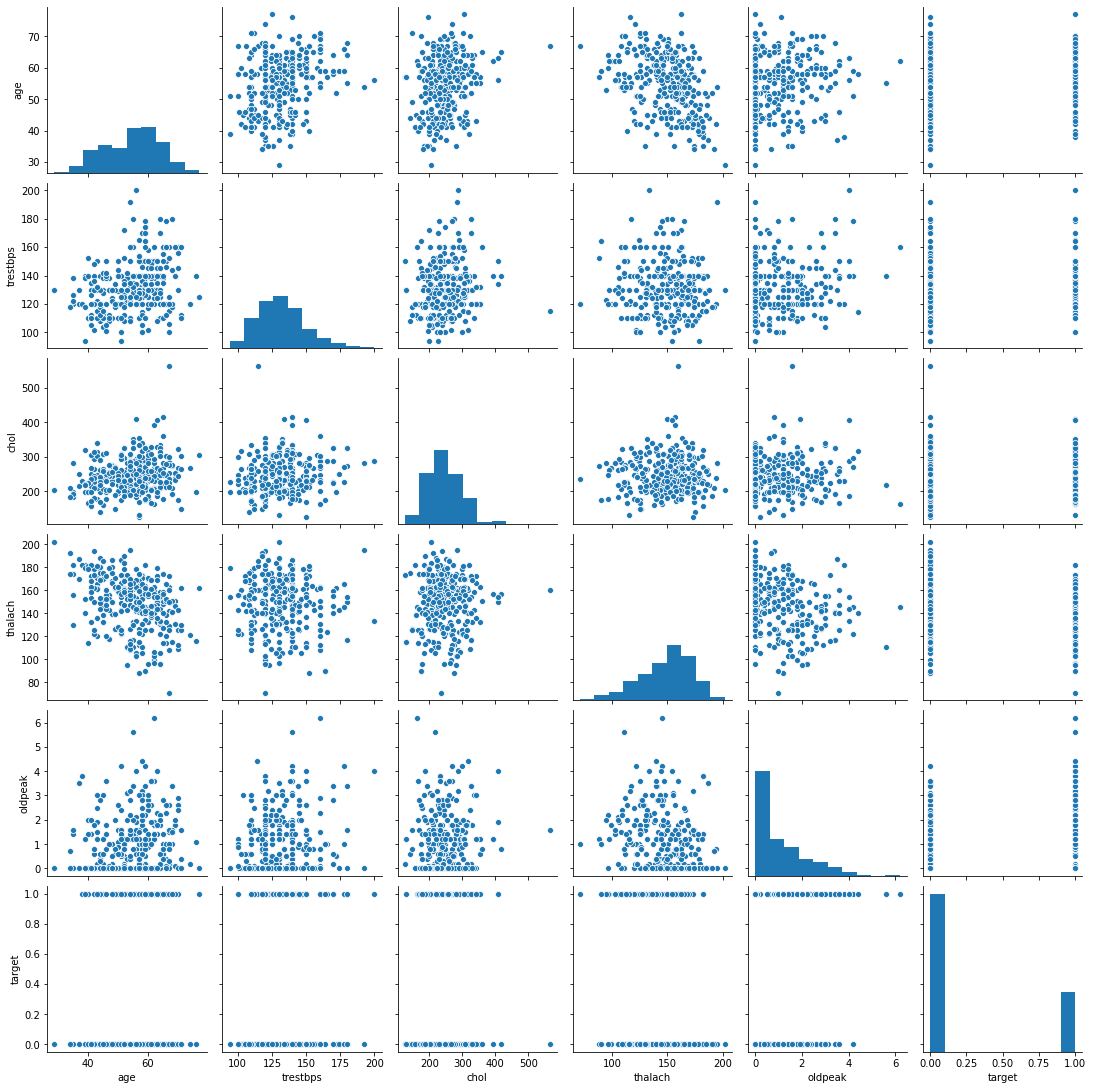

In [90]:
var = ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'target']
sns.pairplot(data[var], kind = 'scatter', diag_kind = 'hist')
plt.show()

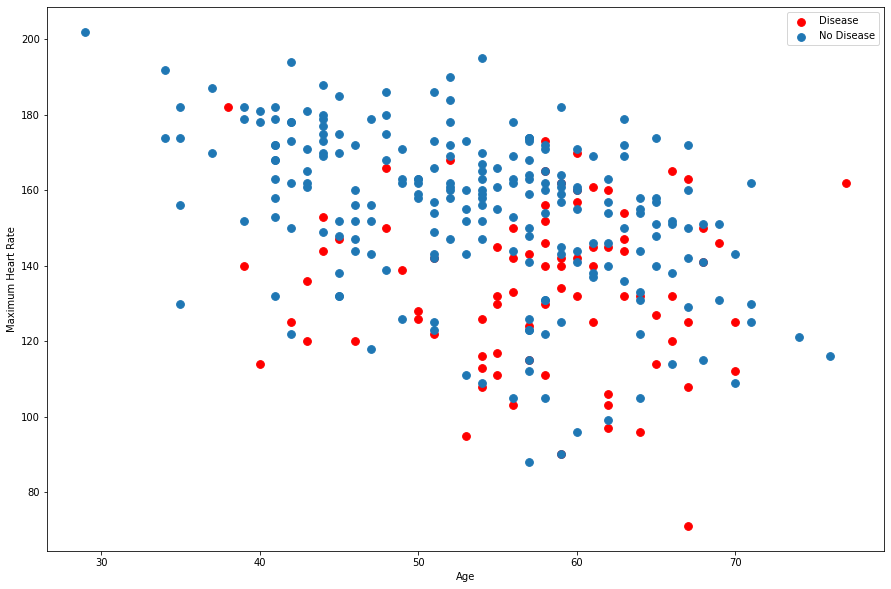

In [91]:
plt.figure(figsize = (15, 10))
plt.scatter(x=data.age[data.target==1], y=data.thalach[(data.target==1)], c="red", s=60)
plt.scatter(x=data.age[data.target==0], y=data.thalach[(data.target==0)], s=60)
plt.legend(["Disease", "No Disease"])
plt.xlabel("Age")
plt.ylabel("Maximum Heart Rate");

Looks like maximum heart rate can be very predictive for the presence of a disease, regardless of age.

## Preprocessing

Split Data

In [92]:
train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

193 train examples
49 validation examples
61 test examples


Transform Pandas Dataframe into Tensorflow's Dataset

In [0]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

The data contains a mixture of categorical and numerical data

Tensorflow's Feature Columns will be used

![alt text](https://3.bp.blogspot.com/-3Wf_6BEn7GE/Wg4GiQ9TXDI/AAAAAAAAEGo/yoLiIyJW1c4Vh-VfP4vVjuaD92rcnVphACLcBGAs/s1600/2.jpg)

Source : https://www.tensorflow.org/tutorials/structured_data/feature_columns#split_the_dataframe_into_train_validation_and_test

In [0]:
feature_columns = []

# numeric columns
for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
  feature_columns.append(feature_column.numeric_column(header))

# bucketized columns
age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
feature_columns.append(age_buckets)

# indicator columns
thal = feature_column.categorical_column_with_vocabulary_list(
      'thal', ['fixed', 'normal', 'reversible'])
thal_one_hot = feature_column.indicator_column(thal)
feature_columns.append(thal_one_hot)

# embedding columns
thal_embedding = feature_column.embedding_column(thal, dimension=8)
feature_columns.append(thal_embedding)

# crossed columns
crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
crossed_feature = feature_column.indicator_column(crossed_feature)
feature_columns.append(crossed_feature)

Create a feature layer

In [0]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [0]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

## Model

Build binary classifier

In [98]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=100)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Epoch 1/100
7/7 [==============================] - 2s 226ms/step - loss: 1.2963 - accuracy: 0.6373 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 1.0829 - accuracy: 0.5751 - val_loss: 1.2817 - val_accuracy: 0.6531
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 0.6730 - accuracy: 0.7047 - val_loss: 0.6169 - val_accuracy: 0.6939
Epoch 4/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6372 - 

In [99]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

2/2 [==============================] - 0s 7ms/step - loss: 0.3744 - accuracy: 0.8197
Accuracy 0.8196721
